In [12]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : OG8pWE7d 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : sMn3-gGx
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

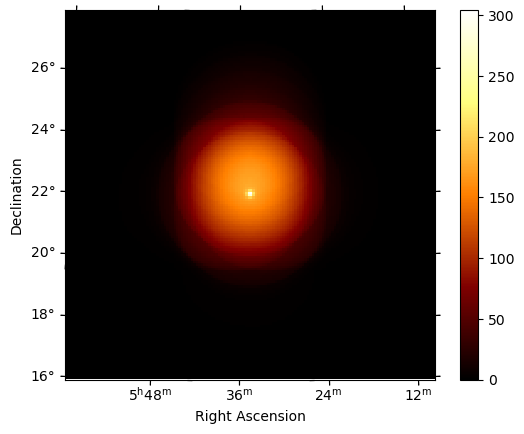

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models_input = Models(source_model)
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

asimov = True
if asimov:
    dataset_standard.counts = dataset_standard.npred()
    
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(    "spatial binsize = ",    binsize)

print(dataset_standard)
fit = Fit()
result = fit.run(dataset_standard)

In [4]:
shift = 0.8
dataset_shifted = MapDataset.read(f"stacked_shifted{shift}.fits.gz")

models_shifted = Models(source_model)
bkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted.name)
bkg_model_shifted.parameters['tilt'].frozen  = False
models_shifted.append(bkg_model_shifted)
dataset_shifted.models = models_shifted

In [5]:
eaxis = dataset_standard.geoms['geom'].axes[0].center.value
eaxis_shifted = dataset_shifted.geoms['geom'].axes[0].center.value

In [6]:
%%time
fit = Fit()
result = fit.run(dataset_shifted)

CPU times: user 2.66 s, sys: 8.52 ms, total: 2.67 s
Wall time: 2.68 s


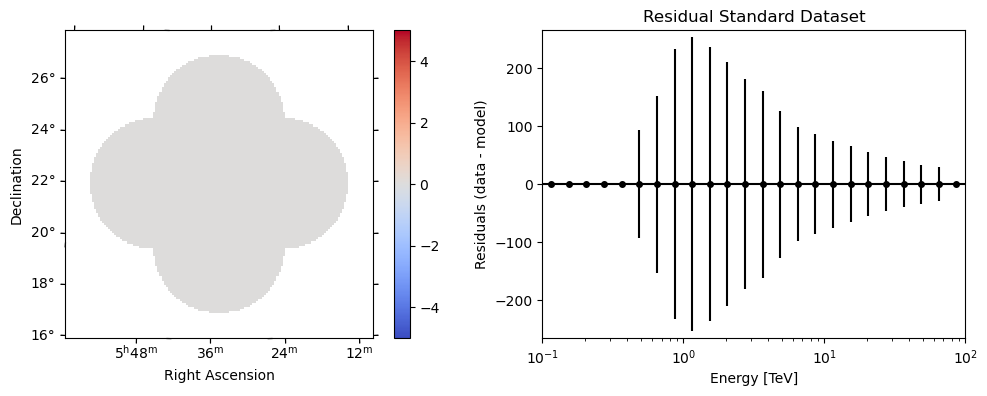

In [7]:
dataset_standard.plot_residuals()
fig =plt.gcf()
plt.title("Residual Standard Dataset")
fig.savefig("plots/2-Residual_st.pdf")

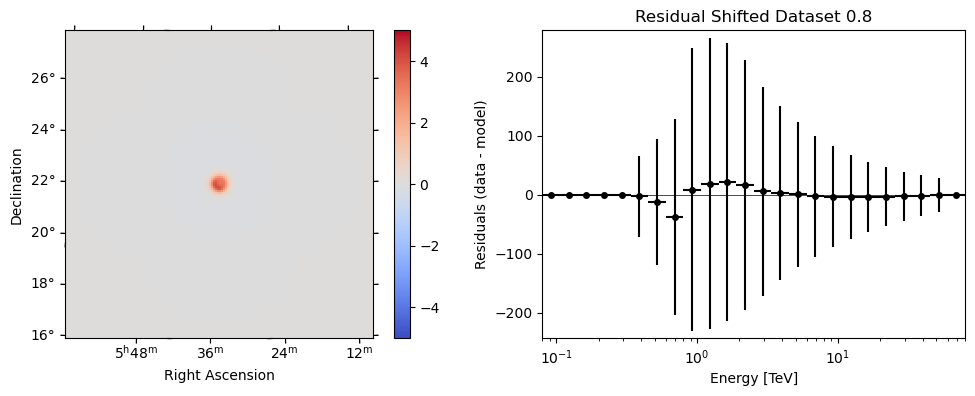

In [8]:
dataset_shifted.plot_residuals()
fig =plt.gcf()
plt.title(f"Residual Shifted Dataset {shift}")
fig.savefig(f"plots/2-Residual_sh_{shift}.pdf")

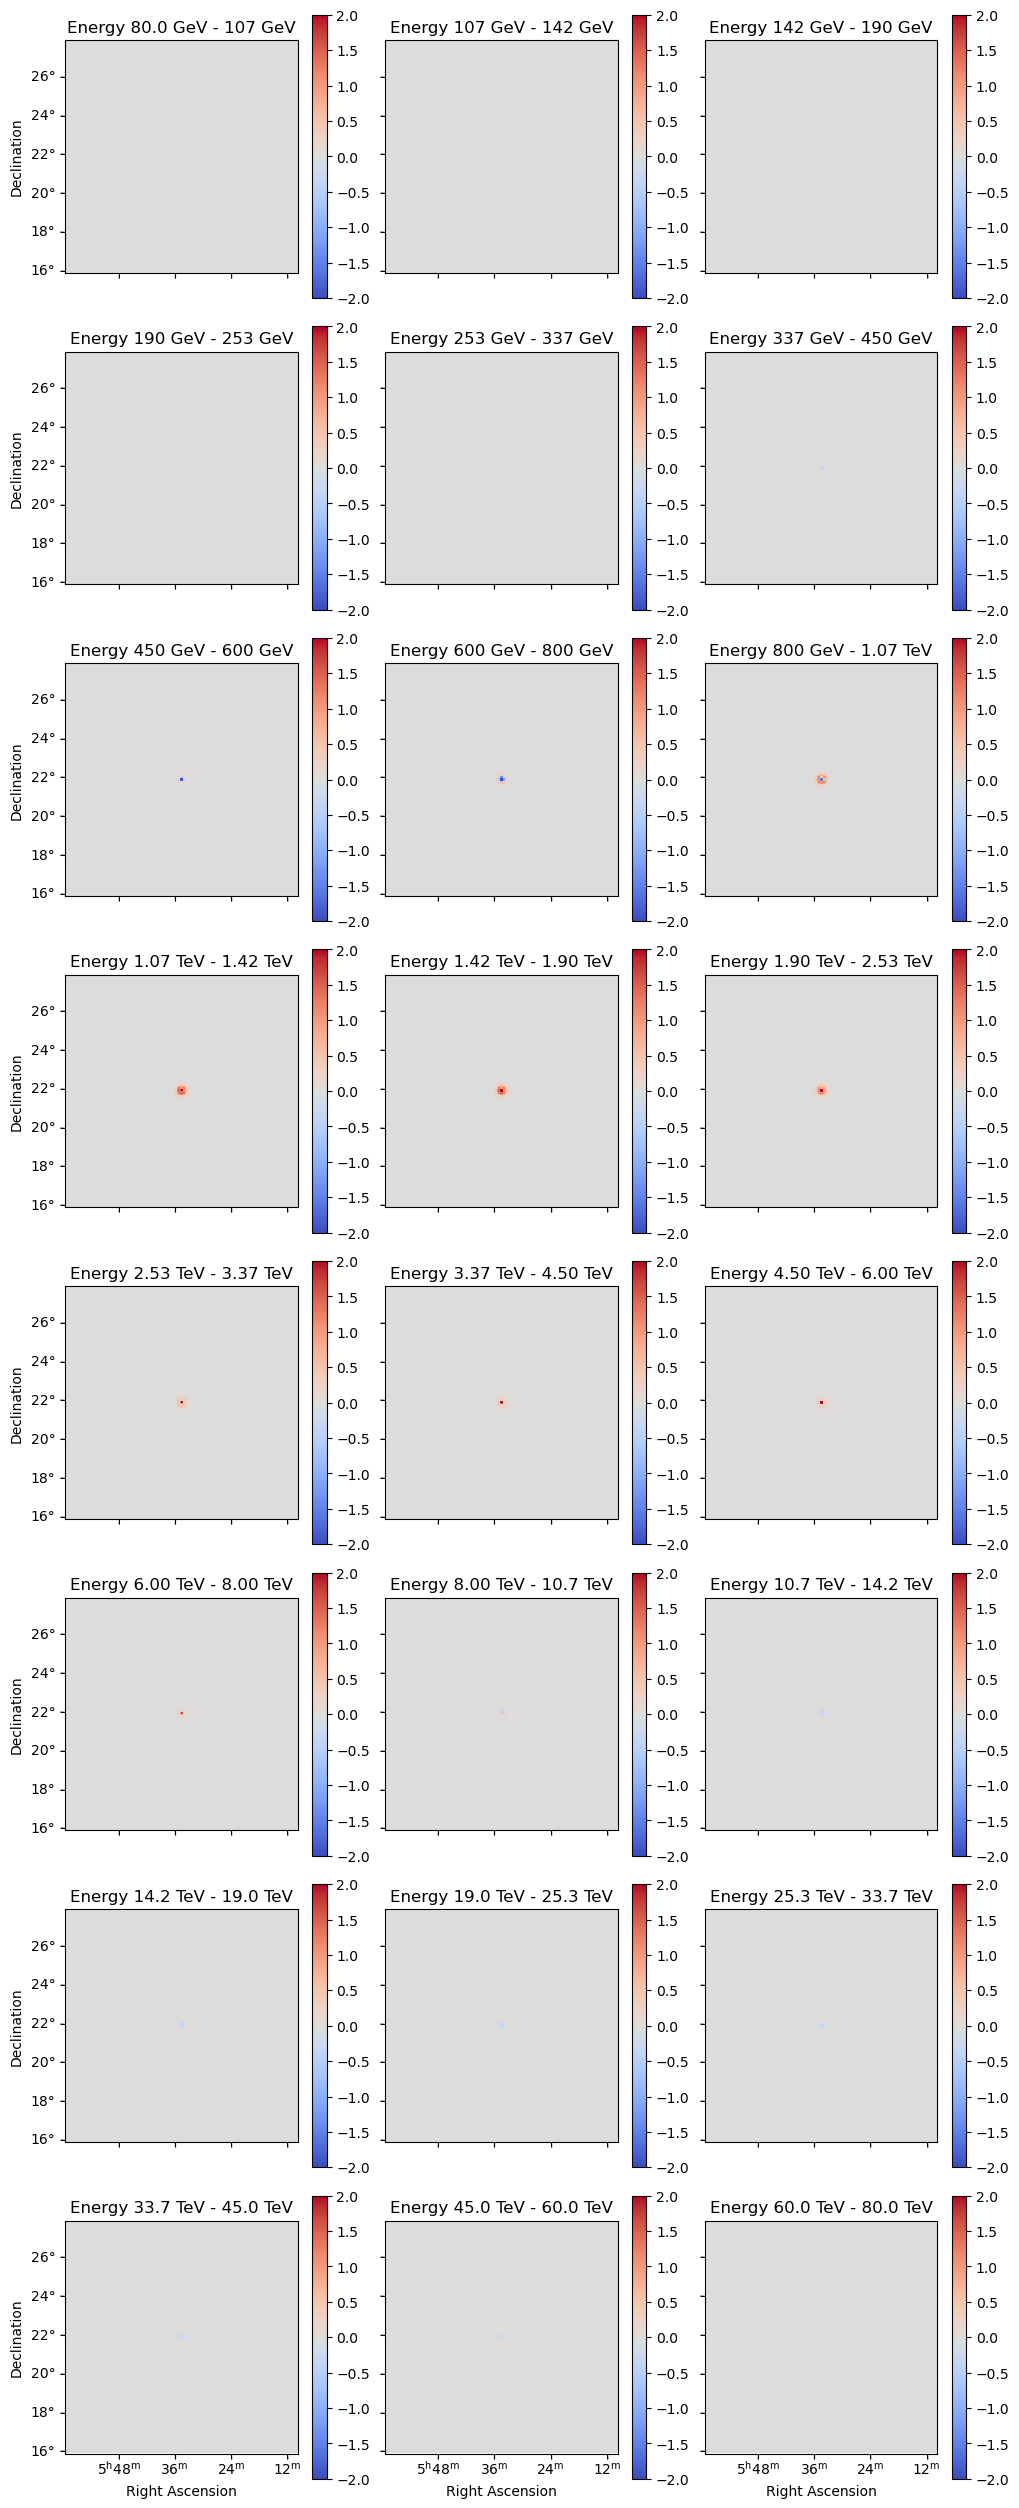

In [9]:
dataset_shifted.residuals().plot_grid(add_cbar = 1, cmap = 'coolwarm',
                                     vmax = 2, vmin = -2);

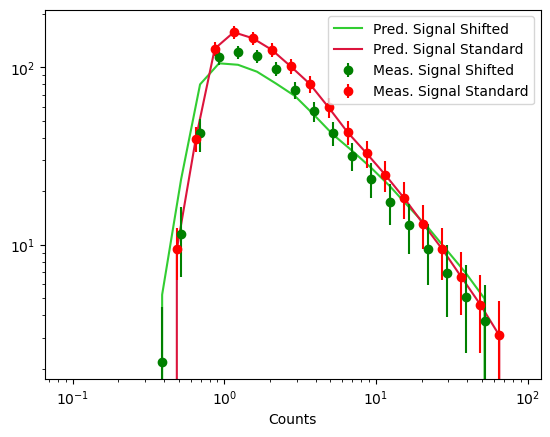

In [10]:
signal_shifted = dataset_shifted.npred_signal().data.sum(axis=2).sum(axis=1)
signal_standard = dataset_standard.npred_signal().data.sum(axis=2).sum(axis=1)

err_signal_shifted = np.sqrt(signal_shifted)
err_signal_standard = np.sqrt(signal_standard)


excess_shifted = (dataset_shifted.counts.data- dataset_shifted.npred_background().data)
excess_shifted = excess_shifted.sum(axis=2).sum(axis=1)
excess_standard = (dataset_standard.counts.data- dataset_standard.npred_background().data)
excess_standard = excess_standard.sum(axis=2).sum(axis=1)


plt.plot(eaxis_shifted, signal_shifted, label= "Pred. Signal Shifted", color = 'limegreen')
plt.plot(eaxis, signal_standard, label = "Pred. Signal Standard", color = 'crimson')

plt.errorbar(eaxis_shifted, excess_shifted, yerr = err_signal_shifted, fmt =  'o',
             label = "Meas. Signal Shifted", color = 'green')
plt.errorbar(eaxis, excess_standard,yerr = err_signal_standard, 
         fmt =  'o', label = "Meas. Signal Standard", color = 'red')

plt.legend()
plt.loglog()
plt.xlabel("Energy [TeV]")
plt.xlabel("Counts")
fig =plt.gcf()
fig.savefig(f"plots/2-Counts_{shift}.pdf")

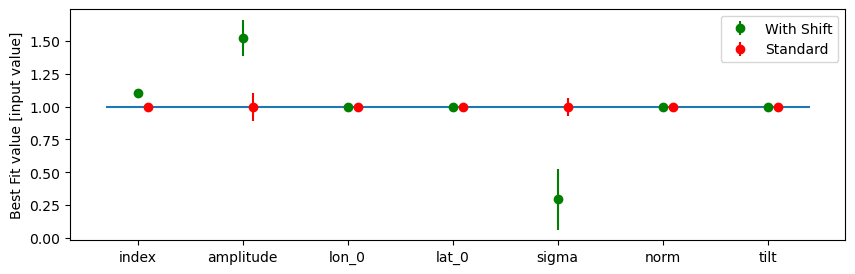

In [11]:
fig = plt.figure(figsize = (10,3))
par_standard = dataset_standard.models.parameters.free_parameters
par_shifted = dataset_shifted.models.parameters.free_parameters

inputs = models_input.parameters.free_parameters.value
inputs = np.append(inputs, [1.0, 1.0, 1.0])
names = []
for i in range(len( par_shifted)):
    p_st = par_standard[i].copy()
    p_sh = par_shifted[i].copy()
    names.append(p_st.name)
    if p_st.name == "tilt":
        p_st.value +=1 
        p_sh.value +=1 
        
    plt.errorbar(i, p_st.value / inputs[i],yerr = p_st.error/inputs[i] , fmt = 'o', color = 'green',
                label = 'With Shift')
    plt.errorbar(i+ 0.1, p_sh.value / inputs[i],yerr = p_sh.error/inputs[i], fmt =  'o', color = 'red',
                label = 'Standard')
xlim = plt.xlim()
plt.hlines(1, xlim[0], xlim[1] )    
plt.xticks(np.arange(len(names)), names);    
plt.ylabel("Best Fit value [input value]")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

fig.savefig(f"plots/2-Best_Fit_{shift}.png")